### <center> APIs and Modules for Tensorflow </center> 
There are multiple APIs available to support different IOPS and Deep learning.
1. Keras - High level API for deep learning.
2. Data
3. Estimator

In [6]:
# Print out multiple lines in output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# Import modules
import os
import numpy as np 

import tensorflow as tf
from tensorflow import keras
tf.__version__
keras.__version__

'2.2.4-tf'

In [8]:
from matplotlib import pyplot as plt
%matplotlib notebook

In [9]:
# Import MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape
x_test.shape

# Normalize dataset
x_train, x_test = x_train/255.0, x_test/255.0

(60000, 28, 28)

(10000, 28, 28)

### 1. Keras API

In [6]:
# Create and evaluate a sequential model in Keras
epochs=3
batch_size=32
steps_per_epoch = len(x_train)//batch_size

def build_estimator():
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation=tf.nn.relu))
    model.add(keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_estimator()
model.fit(x_train, y_train, 
          batch_size=batch_size,
         epochs=epochs)
model.summary()
model.evaluate(x_test, y_test)

Epoch 1/3
60000/60000 [==============================] - 7s 114us/sample - loss: 0.2119 - accuracy: 0.9356
Epoch 2/3
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0888 - accuracy: 0.9728
Epoch 3/3
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0613 - accuracy: 0.9808


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  401920    
_________________________________________________________________
dense_1 (Dense)              multiple                  65664     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 48us/sample - loss: 0.0801 - accuracy: 0.9753


[0.08005141494031413, 0.9753]

### Subclassing Keras Model

In [7]:
# Save and load keras models
from tensorflow.keras.models import load_model

model.save('./output/02/mnist_model.h5')
model.save_weights('./output/02/mnist_model_weights.h5')
new_model = load_model('./output/02/mnist_model.h5')
new_model_weights = new_model.load_weights('./output/02/mnist_model_weights.h5')

W0513 13:29:31.057957 4559877568 hdf5_format.py:266] Sequential models without an `input_shape` passed to the first layer cannot reload their optimizer state. As a result, your model isstarting with a freshly initialized optimizer.


In [ ]:
class MyMnistModel(tf.keras.Model):
    def __init__(self, num_classes=10):
        super(MyMnistModel, self).__init__()
        
        # Define layers
        inputs = tf.keras.Input((28,28))
        self.x0 = tf.keras.layers.Flatten()
        self.x1 = tf.keras.layers.Dense(512, activation=tf.nn.relu, name='d1')
        self.x2 = tf.keras.layers.Dropout(0.2)
        self.predictions = tf.layers.Dense(10, activation=tf.nn.softmax, name='d2')
    
    def call(self, inputs):
        x = self.x0(inputs)
        x = self.x1(x)
        x = self.x2(x)
        return self.predictions(x)

sub_model = MyMnistModel()
sub_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

sub_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
sub_model.summary()

### 2. Data API - Building data pipelines

To build data pipelines, we need to read data from different source and make iterable dataset function to feed into transformation and analytical pipelines.
- Build from numpy array
- From CSV
- From TFRecord

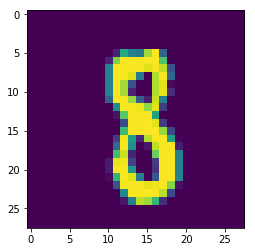

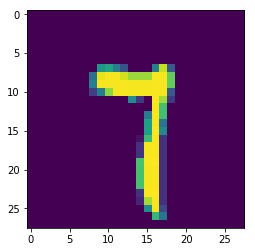

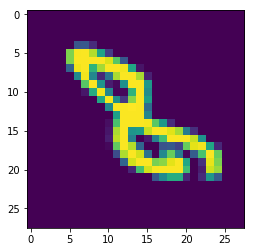

In [20]:
# Convert numpy arrays into dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(10).shuffle(10000)

# Map image functin to data `tf.image`
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset)

for i, item in enumerate(train_dataset):
    plt.imshow(tf.squeeze(iterator.get_next()[0]).numpy())
    plt.show()
    
    if i==2:
        break

In [79]:
# Read from csv file
file = './data/Data.csv'
default_value = ['0','missing',0.0,0.0,'missing'] # replace Null with defaults
dataset = tf.data.experimental.CsvDataset(file, 
                                          record_defaults=default_value,
                                         header=True)

In [78]:
# Batch add another dimension and group values as defined number 
# Shuffle data based on buffer size
dataset = dataset.batch(4, drop_remainder=True).shuffle(15)
iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)

for item in dataset:
    iterator.get_next()

(<tf.Tensor: id=3307, shape=(4,), dtype=string, numpy=array([b'5', b'6', b'7', b'8'], dtype=object)>,
 <tf.Tensor: id=3308, shape=(4,), dtype=string, numpy=array([b'Germany', b'France', b'Spain', b'France'], dtype=object)>,
 <tf.Tensor: id=3309, shape=(4,), dtype=float32, numpy=array([40., 35.,  0., 48.], dtype=float32)>,
 <tf.Tensor: id=3310, shape=(4,), dtype=float32, numpy=array([    0., 58000., 52000., 79000.], dtype=float32)>,
 <tf.Tensor: id=3311, shape=(4,), dtype=string, numpy=array([b'Yes', b'Yes', b'No', b'Yes'], dtype=object)>)

(<tf.Tensor: id=3322, shape=(4,), dtype=string, numpy=array([b'1', b'2', b'3', b'4'], dtype=object)>,
 <tf.Tensor: id=3323, shape=(4,), dtype=string, numpy=array([b'France', b'Spain', b'Germany', b'Spain'], dtype=object)>,
 <tf.Tensor: id=3324, shape=(4,), dtype=float32, numpy=array([44., 27., 30., 38.], dtype=float32)>,
 <tf.Tensor: id=3325, shape=(4,), dtype=float32, numpy=array([72000., 48000., 54000., 61000.], dtype=float32)>,
 <tf.Tensor: id=3326, shape=(4,), dtype=string, numpy=array([b'No', b'Yes', b'No', b'No'], dtype=object)>)

In [98]:
# Write array to TF Record and read from it
data = {
    'ID': 1234,
'Name': ['Pankaj','Sharma'],
'Scores': [45.6, 97.2]
}


def write_to_tfrecord(fname, data):
    writer = tf.io.TFRecordWriter(fname)
    feature = {}
    feature['ID'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[data['ID']]))
    feature['Name'] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[n.encode('utf-8') for n in data['Name']]))
    feature['Scores'] = tf.train.Feature(float_list=tf.train.FloatList(value=data['Scores']))
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()
    writer.write(serialized)
    writer.close()

write_to_tfrecord('./data/test.tfrecord', data)

In [104]:
# Read from tf record file
dataset = tf.data.TFRecordDataset('./data/test.tfrecord')

# Data is in serialized format - decode 
for item in dataset:
    print(item)

tf.Tensor(b'\nB\n\x1a\n\x04Name\x12\x12\n\x10\n\x06Pankaj\n\x06Sharma\n\x0c\n\x02ID\x12\x06\x1a\x04\n\x02\xd2\t\n\x16\n\x06Scores\x12\x0c\x12\n\n\x08ff6Bff\xc2B', shape=(), dtype=string)


In [107]:
dataset = tf.data.TFRecordDataset('./data/test.tfrecord')

def parse_function(example_proto):
    keys_to_features = {'ID':tf.io.FixedLenFeature([], dtype=tf.int64),
                       'Name': tf.io.VarLenFeature(dtype=tf.string),
                        'Scores': tf.io.VarLenFeature(dtype=tf.float32)
                       }
    parsed_features = tf.io.parse_single_example(serialized=example_proto, features=keys_to_features)
    return parsed_features['ID'], parsed_features['Name'], parsed_features['Scores']

dataset = dataset.map(parse_function)
iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
# array is retrieved as one item
item = iterator.get_next()
print(item)
#print(item.numpy())
#print(item[2].numpy())

(<tf.Tensor: id=3794, shape=(), dtype=int64, numpy=1234>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0xb5adc0780>, <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0xb5ae25860>)


In [109]:
print("ID: ",item[0].numpy())
name = item[1].values.numpy()
name1= name[0].decode()
name2 = name[1].decode('utf8')
print("Name:",name1,",",name2)
print("Scores: ",item[2].values.numpy())

ID:  1234
Name: Pankaj , Sharma
Scores:  [45.6 97.2]


### Write a function to ingest data in pipeline

In [1]:
def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(records = value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))          
            label = features.pop(LABEL_COLUMN)         
            return features, label

        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename = filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(filenames = file_list).map(map_func = decode_csv)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(count = num_epochs).batch(batch_size = batch_size)
        return dataset.make_one_shot_iterator().get_next()
    return _input_fn

In [9]:
# Call function from model function snippet

args = {'train_data_paths': 'path-for-train-files',
       'batch_size': 512,
       'train_steps': 100000,
       'eval_data_paths': 'path-for-eval-files',
       'start_delay_secs': 60,
       'throttle_secs': 100}

train_spec = tf.estimator.TrainSpec(
    input_fn = read_dataset(filename = args['train_data_paths'], 
                            mode = tf.estimator.ModeKeys.TRAIN, 
                            batch_size = args['batch_size']),
    max_steps = args['train_steps'])

#exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)

eval_spec = tf.estimator.EvalSpec(
    input_fn = read_dataset(filename = args['eval_data_paths'], 
                            mode = tf.estimator.ModeKeys.EVAL, 
                            batch_size = args['batch_size']),
    steps = None,
    start_delay_secs = args['start_delay_secs'],
    throttle_secs = args['throttle_secs'],
    #exporters = exporter
)

#tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

### 3. Estimator API